# Tawfiq Moharaq
https://www.linkedin.com/in/tawfiq-moharaq-1a37ba2a3/recent-activity/all/

In [ ]:
# =====  Install and Imports =====
!pip install kagglehub sentence-transformers scikit-learn imbalanced-learn xgboost matplotlib pandas numpy

import os, re, json, random, warnings, glob
import numpy as np
import pandas as pd

from typing import List, Dict, Tuple
from dataclasses import dataclass

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

import kagglehub

warnings.filterwarnings("ignore", category=UserWarning)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("Imports ready")

Imports ready


In [ ]:
# ===== Download Kaggle Dataset =====
# Dataset: siddharthm1698/coursera-course-dataset

path = kagglehub.dataset_download("siddharthm1698/coursera-course-dataset")
print("Kaggle dataset path:", path)

# List files for visibility
files = sorted(glob.glob(os.path.join(path, "**", "*.*"), recursive=True))
print(f"Found {len(files)} files.")
for f in files[:20]:
    print(" -", os.path.relpath(f, path))
if len(files) > 20:
    print(" ...")


Using Colab cache for faster access to the 'coursera-course-dataset' dataset.
Kaggle dataset path: /kaggle/input/coursera-course-dataset
Found 1 files.
 - coursea_data.csv


In [ ]:
# ===== Helper functions (cleaning + schema coercion) =====

def clean_text(s: str) -> str:
    """Minimal text cleaning: lowercase + remove non-alphanumerics."""
    if not isinstance(s, str): return ""
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def map_difficulty_to_bucket(d: str) -> str:
    """Normalize course difficulty into coarse buckets."""
    if not isinstance(d, str) or not d.strip():
        return "mixed"
    d = d.lower()
    if "begin" in d: return "beginner"
    if "intermed" in d: return "intermediate"
    if "adv" in d or "expert" in d: return "advanced"
    return "mixed"

# Try to coerce diverse column names to required schema
REQUIRED = ["course_title","course_difficulty","course_rating","course_students_enrolled"]

CANDIDATE_MAP = {
    "course_title": ["course_title","title","course name","course","name"],
    "course_difficulty": ["course_difficulty","difficulty","level","course_level","course difficulty"],
    "course_rating": ["course_rating","rating","rating out of 5","course_rating_out_of_5","stars","avg rating","average rating"],
    "course_students_enrolled": ["course_students_enrolled","students","enrolled","num_students","students enrolled","enrollment","no_of_enrolled","subscribers","num_subscribers"]
}

def coerce_schema(df: pd.DataFrame) -> pd.DataFrame:
    cols_lower = {c: c for c in df.columns}
    # Build lowercase helper
    lower_map = {c.lower(): c for c in df.columns}
    rename = {}
    for target, candidates in CANDIDATE_MAP.items():
        found_col = None
        for cand in candidates:
            if cand in df.columns:
                found_col = cand
                break
            if cand.lower() in lower_map:
                found_col = lower_map[cand.lower()]
                break
        if found_col is not None:
            rename[found_col] = target
    df = df.rename(columns=rename)
    return df

def select_required(df: pd.DataFrame) -> pd.DataFrame:
    """Try to construct the required schema; use proxies if needed."""
    df = coerce_schema(df.copy())

    # If rating looks like 0-100, scale to 0-5
    if "course_rating" in df.columns:
        cr = pd.to_numeric(df["course_rating"], errors="coerce")
        if cr.notna().any():
            # Heuristic: if median > 5, assume percentage
            if np.nanmedian(cr) > 5:
                df["course_rating"] = (cr / 20.0).clip(0, 5)
            else:
                df["course_rating"] = cr.clip(0, 5)

    # If students missing but reviews exist, use as proxy
    if "course_students_enrolled" not in df.columns:
        for alt in ["num_reviews","reviews","no_of_reviews","number of reviews","n_reviews"]:
            if alt in df.columns:
                df["course_students_enrolled"] = pd.to_numeric(df[alt], errors="coerce").fillna(0.0)
                break

    # Minimal keep
    keep = [c for c in REQUIRED if c in df.columns]
    return df[keep].dropna().copy()

print("Helpers ready")


Helpers ready


In [ ]:
# ===== Load all CSVs and build `courses` =====

csvs = sorted(glob.glob(os.path.join(path, "**", "*.csv"), recursive=True))
print(f"Found {len(csvs)} CSV files")

frames = []
for csv in csvs:
    try:
        tmp = pd.read_csv(csv)
        tmp2 = select_required(tmp)
        if not tmp2.empty:
            frames.append(tmp2)
            print(f"   Loaded: {os.path.basename(csv)} -> shape {tmp2.shape}")
        else:
            print(f"  - Skipped (no required columns): {os.path.basename(csv)}")
    except Exception as e:
        print(f"  ! Error reading {os.path.basename(csv)}: {e}")

if not frames:
    raise RuntimeError("No CSV with required columns was found. Please inspect dataset files.")

courses = pd.concat(frames, ignore_index=True).dropna().copy()

# Final sanitation
courses["course_title"] = courses["course_title"].astype(str)
courses["course_difficulty"] = courses["course_difficulty"].astype(str).map(map_difficulty_to_bucket)
courses["course_rating"] = pd.to_numeric(courses["course_rating"], errors="coerce").clip(0, 5).fillna(0.0)
courses["course_students_enrolled"] = pd.to_numeric(courses["course_students_enrolled"], errors="coerce").fillna(0.0)

print("courses ready:", courses.shape)
courses.head()


Found 1 CSV files
   Loaded: coursea_data.csv -> shape (891, 4)
courses ready: (891, 4)


,course_title,course_difficulty,course_rating,course_students_enrolled
0,(ISC)² Systems Security Certified Practitioner...,beginner,4.7,0.0
1,A Crash Course in Causality: Inferring Causal...,intermediate,4.7,0.0
2,A Crash Course in Data Science,mixed,4.5,0.0
3,A Law Student's Toolkit,mixed,4.7,0.0
4,A Life of Happiness and Fulfillment,mixed,4.8,0.0


In [ ]:
# ===== TF-IDF + synthetic students + training set =====

# Cleaned title for TF-IDF
courses["course_title_clean"] = courses["course_title"].apply(clean_text)

# Fit TF-IDF on course titles
tfidf_titles = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=2)
tfidf_titles.fit(courses["course_title_clean"])

# Domain keywords per major (for synthetic students)
MAJORS_KEYWORDS = {
    'Computer Science': ['python','computer','programming','software','algorithms','ai','machine learning'],
    'Data Science':     ['data','machine learning','statistics','python','deep learning','analysis'],
    'Business':         ['marketing','business','finance','management','entrepreneurship'],
    'Health':           ['health','medical','biology','care','nursing'],
    'Engineering':      ['engineering','mechanics','design','electronics','robotics'],
}
MAJORS = list(MAJORS_KEYWORDS.keys())

def generate_students(n=300, seed=42):
    rng = random.Random(seed)
    rows = []
    for i in range(1, n+1):
        major = rng.choice(MAJORS)
        interests = ", ".join(rng.sample(MAJORS_KEYWORDS[major], k=2))
        level = rng.choice(['Beginner','Intermediate','Expert'])
        rows.append({'StudentID': f'S{i}','Major': major,'Interests': interests,'Level': level})
    return pd.DataFrame(rows)

students = generate_students(300, seed=SEED)

def interest_similarity(interests_text: str, title: str) -> float:
    """Cosine similarity between student's interests and a course title using SAME TF-IDF."""
    v_i = tfidf_titles.transform([clean_text(interests_text)])
    v_t = tfidf_titles.transform([clean_text(title)])
    return float(cosine_similarity(v_i, v_t).ravel()[0])

def baseline_score(student_interests: str, student_level: str, row: pd.Series) -> Tuple[float, float]:
    """
    Synthetic scoring rule (keeps earlier spirit):
    - 60%: text similarity (0..1)
    - 20%: course rating (scaled to 0..1 by /5)
    - 20%: difficulty suitability per level
    Return (score 1..5, similarity)
    """
    sim = interest_similarity(student_interests, row["course_title"])
    rating_w = (float(row["course_rating"])/5.0) * 20.0
    diff = map_difficulty_to_bucket(row["course_difficulty"])

    if student_level=='Beginner':
        diff_w = 25 if diff=='beginner' else (7 if diff=='intermediate' else (10 if diff=='mixed' else -10))
    elif student_level=='Intermediate':
        diff_w = 25 if diff=='intermediate' else (5 if diff=='beginner' else (10 if diff=='mixed' else 10))
    else:  # Expert
        diff_w = 25 if diff=='advanced' else (10 if diff=='intermediate' else (7 if diff=='mixed' else -5))

    score_0_100 = np.clip(sim*60 + rating_w + diff_w, 0, 100)
    score_1_5 = round((score_0_100/100)*5, 3)
    return score_1_5, sim

# Build training pairs: sample subset of courses per student for tractability
rows = []
rng = np.random.default_rng(SEED)
for _, s in students.iterrows():
    idxs = rng.choice(len(courses), size=min(250, len(courses)), replace=False)
    sub = courses.iloc[idxs]
    for _, r in sub.iterrows():
        score, sim = baseline_score(s["Interests"], s["Level"], r)
        rows.append({
            "Level": s["Level"],
            "interest_sim": sim,
            "course_title_clean": r["course_title_clean"],
            "course_difficulty": r["course_difficulty"],
            "course_rating": float(r["course_rating"]),
            "course_students_enrolled": float(r["course_students_enrolled"]),
            "target": score
        })

train_df = pd.DataFrame(rows)
print("training frame:", train_df.shape)
train_df.head()


training frame: (75000, 7)


,Level,interest_sim,course_title_clean,course_difficulty,course_rating,course_students_enrolled,target
0,Intermediate,0.0,teamwork skills communicating effectively in g...,beginner,4.8,0.0,1.21
1,Intermediate,0.0,introduction to personal branding,beginner,4.4,0.0,1.13
2,Intermediate,0.0,foundations of business strategy,beginner,4.8,0.0,1.21
3,Intermediate,0.0,probability and statistics to p or not to p,beginner,4.6,0.0,1.17
4,Intermediate,0.0,actualizaci n en el manejo del paciente con di...,mixed,4.8,0.0,1.46


In [ ]:
# ===== Preprocess + Train 3 Models (RF / Ridge / ElasticNet) =====

text_col = 'course_title_clean'
cat_cols  = ['Level','course_difficulty']
num_cols  = ['course_rating','course_students_enrolled','interest_sim']

# Use the SAME TF-IDF vocabulary to avoid leakage
pre = ColumnTransformer(
    transformers=[
        ('txt', TfidfVectorizer(vocabulary=tfidf_titles.vocabulary_, ngram_range=(1,2), stop_words='english'), text_col),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_cols),
        ('num', 'passthrough', num_cols),
    ],
    sparse_threshold=0.3
)

models = {
    "RandomForestRegressor": RandomForestRegressor(n_estimators=350, random_state=SEED, n_jobs=-1),
    "Ridge": Ridge(alpha=1.0, random_state=SEED),
    "ElasticNet": ElasticNet(alpha=0.05, l1_ratio=0.5, random_state=SEED)
}

X = train_df[[text_col]+cat_cols+num_cols]
y = train_df["target"]

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=SEED)

results = []
fitted = {}

for name, model in models.items():
    pipe = Pipeline([('prep', pre), ('model', model)])
    pipe.fit(X_tr, y_tr)
    preds = pipe.predict(X_te)

    rmse = float(np.sqrt(mean_squared_error(y_te, preds)))
    mae  = float(mean_absolute_error(y_te, preds))
    r2   = float(r2_score(y_te, preds))

    results.append({"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2})
    fitted[name] = pipe

results_df = pd.DataFrame(results).sort_values("MAE").reset_index(drop=True)
print(" Model Comparison (sorted by MAE):")
print(results_df)

best_name = results_df.iloc[0]["Model"]
best_pipe = fitted[best_name]
print(f"\n Selected BEST model: {best_name}")


 Model Comparison (sorted by MAE):
                   Model      RMSE       MAE        R2
0  RandomForestRegressor  0.020374  0.001739  0.998683
1                  Ridge  0.395493  0.339630  0.503787
2             ElasticNet  0.457114  0.386443  0.337114

 Selected BEST model: RandomForestRegressor


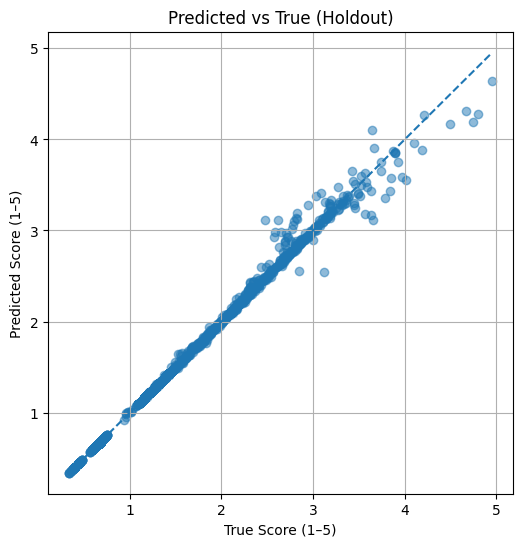

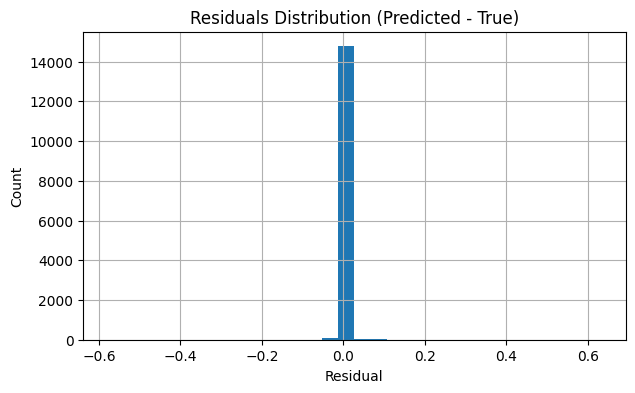

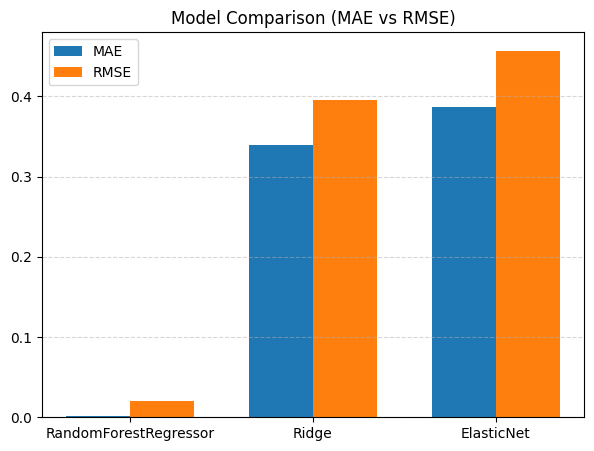

In [ ]:
# ===== Visualizations =====

# 1) Predicted vs True scatter with y=x reference
preds_best = best_pipe.predict(X_te)

plt.figure(figsize=(6,6))
plt.scatter(y_te, preds_best, alpha=0.5)
min_val = min(y_te.min(), preds_best.min())
max_val = max(y_te.max(), preds_best.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')
plt.title('Predicted vs True (Holdout)')
plt.xlabel('True Score (1–5)')
plt.ylabel('Predicted Score (1–5)')
plt.grid(True)
plt.show()

# 2) Residuals histogram
residuals = preds_best - y_te
plt.figure(figsize=(7,4))
plt.hist(residuals, bins=30)
plt.title('Residuals Distribution (Predicted - True)')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# 3) Bar chart comparing models (MAE, RMSE)
plt.figure(figsize=(7,5))
x = np.arange(len(results_df))
width = 0.35
plt.bar(x - width/2, results_df["MAE"], width, label="MAE")
plt.bar(x + width/2, results_df["RMSE"], width, label="RMSE")
plt.xticks(x, results_df["Model"])
plt.title("Model Comparison (MAE vs RMSE)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


In [ ]:
# ===== Inference with User Input (Top-K Recommendations) =====

def infer_topk(user_interests: str, user_level: str, top_k: int = 10) -> pd.DataFrame:
    # Build inference frame from original courses
    inf_df = courses[['course_title','course_difficulty','course_rating','course_students_enrolled','course_title_clean']].copy()

    # Compute personalized interest similarity using SAME TF-IDF
    user_vec = tfidf_titles.transform([clean_text(user_interests)])
    sims = []
    for title in inf_df['course_title'].tolist():
        t_vec = tfidf_titles.transform([clean_text(title)])
        sims.append(float(cosine_similarity(user_vec, t_vec).ravel()[0]))
    inf_df['interest_sim'] = sims

    # Build model features
    inf_pred = inf_df.copy()
    inf_pred.insert(0, 'Level', user_level)

    # Predict score 1..5
    feats = ['course_title_clean','Level','course_difficulty','course_rating','course_students_enrolled','interest_sim']
    scores = best_pipe.predict(inf_pred[feats])
    out = inf_df[['course_title','course_difficulty','course_rating','course_students_enrolled']].copy()
    out['PredictedScore(1-5)'] = np.round(scores, 3)

    recs = out.sort_values('PredictedScore(1-5)', ascending=False).head(top_k).reset_index(drop=True)
    return recs

# Simple interactive inputs (safe defaults for notebooks)
def safe_input(prompt: str, default: str = "") -> str:
    try:
        s = input(prompt).strip()
        return s or default
    except Exception:
        return default

print("\n Demo — Personalized Recommendations")
user_interests = safe_input("Enter your interests (e.g., machine learning, python, data): ", "machine learning, python, data")
user_level     = safe_input("Your level (Beginner/Intermediate/Expert): ", "Intermediate")

recs = infer_topk(user_interests, user_level, top_k=10)
print("\n Top-10 Recommended Courses:")
display(recs)


In [ ]:
# ===== Save best model and metadata =====
from joblib import dump

MODEL_DIR = "model_store"
os.makedirs(MODEL_DIR, exist_ok=True)

model_path = os.path.join(MODEL_DIR, f"{best_name.replace(' ', '_').lower()}_recommender.joblib")
dump(best_pipe, model_path)

meta = {
    "best_model": best_name,
    "metric": "MAE",
    "results": results_df.to_dict(orient="records"),
    "tfidf_vocab_size": len(tfidf_titles.vocabulary_)
}
with open(os.path.join(MODEL_DIR, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

print(" Saved:", model_path)
print(" Saved:", os.path.join(MODEL_DIR, "meta.json"))
